# Quantum Circuit Learning for classification

Reproduction of results in the work of Mitarai et. al. [1] that demonstrate the implementation of Quantum Circuit Learning to perform a simple nonlinear classification task. We use qulacs library to simulate quantum circuits. This implementation is based on the tutorial for using the same technique to fit a sinusoidal function provided in the qulacs documentation: https://dojo.qulacs.org/ja/latest/notebooks/5.1_variational_quantum_eigensolver.html 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer

First of all, we must generate teaching data resembling the one shown in Fig 4(a) of ref. [1]. We perform the training on 100 samples. The constructed data set will consist of 50 samples belonging to class 0 and 50 belonging to class 1. We define the input data points $\mathbf{x}_i = (x_{i,0},x_{i,1})$ and define the teacher vector $f(\mathbf{x}_i)$

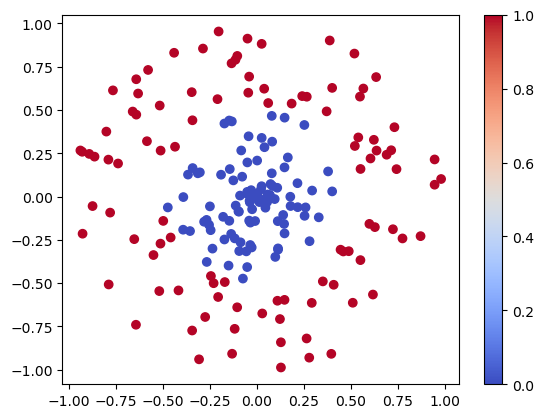

In [3]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)
np.random.seed(0)

num_training_samples = 100 # generate 100 teaching samples of each class


# 100 random samples in class 0
r_min = 0.; r_max = 0.49
r_train = r_min + (r_max - r_min) * np.random.rand(num_training_samples) # random ratio in [0,0.5]
theta_train = 2.0 * np.pi * np.random.rand(num_training_samples) # random angle

# we store the x_0 and x_1 coordinates of class 0 training samples
x_0_class0 = r_train * np.cos(theta_train) 
x_1_class0= r_train * np.sin(theta_train)
# these samples will be labeled as class 0, which corresponds to the teaching value [0,1]
f_train0 = [np.asarray([0,1]) for i in range(num_training_samples)] # corresponding labels

# 100 samples in class 1
r_min = 0.51; r_max = 1.0
r_train = r_min + (r_max - r_min) * np.random.rand(num_training_samples)
theta_train = 2.0 * np.pi * np.random.rand(num_training_samples)

# we store the x and y coordinates of class 1 training samples
x_0_class1 = r_train * np.cos(theta_train)
x_1_class1= r_train * np.sin(theta_train)
# these samples will be labeled as class 1, which corresponds to the teaching value [1,0]
f_train1 = [np.asarray([1,0]) for i in range(num_training_samples)]

# we concatenate the two sets of samples
x_train = np.concatenate([x_0_class0, x_0_class1])
y_train = np.concatenate([x_1_class0, x_1_class1])
f_train = f_train0 + f_train1
train_samples = [np.asarray([x_train[i], y_train[i]]) for i in range(len(x_train))]


color = [f[0]**2 for f in f_train]
plt.scatter(x_train, y_train, c=color, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()



## Prepare quantum state

We define the initial state to be $\ket{\psi} = \ket{000000}$. And we create the gate $U_{in}(\vec{x_i})$ for embedding the input value $x_i$ in the initial state $\ket{\psi}$. According to reference $[1]$ we define:
$U_{in}(\vec{x_i}) = $
with rotation gates
$\Pi_j R^Z_j(\cos^{-1}x^2_{i,j \ mod \ 2}) R^Y_j(\sin^{-1}x_{i,j \ mod \ 2})$

So input $\vec{x_i}$, is converted into: $\ket{\psi_{in}(\vec{x_i})} = U_{in}(\vec{x_i})\ket{00...0}$


In [4]:
# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

NameError: name 'nqubit' is not defined

In [ ]:
def U_in(sample):
    U = QuantumCircuit(nqubit)

    for j in range(nqubit):
        jmod = j%2
        xij = sample[jmod]
        angle_y = np.arcsin(xij)
        angle_z = np.arccos(xij**2)
        U.add_RY_gate(j, angle_y)
        U.add_RZ_gate(j, angle_z)

    return U

[-2.11531462e-01-9.18448454e-01j -1.78310813e-01+1.63548253e-02j
  5.85457547e-02-1.25004405e-02j -8.57379967e-04-1.13411497e-02j
 -1.78310813e-01+1.63548253e-02j -1.47718395e-03+3.39864416e-02j
 -8.57379967e-04-1.13411497e-02j -2.15697677e-03-1.28374987e-04j
  5.85457547e-02-1.25004405e-02j -8.57379967e-04-1.13411497e-02j
  7.34370827e-04+3.73095181e-03j  7.21148220e-04-4.29199771e-05j
 -8.57379967e-04-1.13411497e-02j -2.15697677e-03-1.28374987e-04j
  7.21148220e-04-4.29199771e-05j  1.03464122e-05-1.36859052e-04j
 -1.78310813e-01+1.63548253e-02j -1.47718395e-03+3.39864416e-02j
 -8.57379967e-04-1.13411497e-02j -2.15697677e-03-1.28374987e-04j
 -1.47718395e-03+3.39864416e-02j  6.36049673e-03+1.14649954e-03j
 -2.15697677e-03-1.28374987e-04j -7.92818403e-05+4.02789319e-04j
 -8.57379967e-04-1.13411497e-02j -2.15697677e-03-1.28374987e-04j
  7.21148220e-04-4.29199771e-05j  1.03464122e-05-1.36859052e-04j
 -2.15697677e-03-1.28374987e-04j -7.92818403e-05+4.02789319e-04j
  1.03464122e-05-1.368590

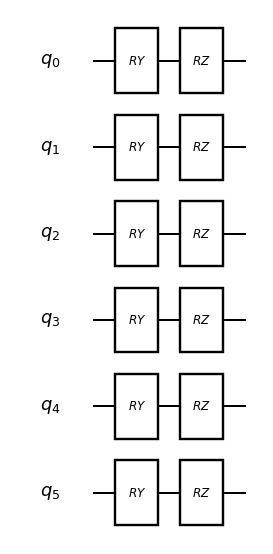

In [ ]:
# Test initial state
sample_i = train_samples[10]
U_in(sample_i).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

circuit_drawer(U_in(sample_i),'mpl')

With the input value codificated into the quantum state, we construct the variational quantum circuit in the same way that we did for the one dimensional fit of $\sin(x)$

In [ ]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

Using ```make_fullgate``` the hamiltonian is then calculated as a sum of X and Z gates multiplied by corresponding coefficients. 

After that, the corresponding time evolution operator is calculated as $U_{rand} = e^{-iHt}$

First of all, we define the parameters of the simulated system

In [ ]:
########  Parameter  #############
nqubit = 6 ## number of qubit
c_depth = 6 ## depth of circuit
time_step = 10 ## elapsed time of time evolution with random Hamiltonian

In [ ]:
#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [ ]:
# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

### 2. Create rotation gates and 3. Create $U(\theta)$

In this step, the previously calculated evolution operator $U_{rand}$ is combined with the rotation gates operator of for the $j = (1,2,...,n)$th qubit:

$U_{rot}(\theta_j^{(i)}) = R^X_j(\theta^{(i)}_{j1})R^Z_j(\theta^{(i)}_{j2})R^X_j(\theta^{(i)}_{j3})$

To create the variational quantum circuit $U(\theta)$:

$U\left(\{ \theta^{(i)}_{j} \}_{i,j} \right) = \prod\limits_{i=1}^d \left( \left( \prod\limits_{j=1}^n U_{rot}(\theta_j^{(i)}) \right) . U_{rand} \right)$
 
 
suffix $i$ is representing the layer of the quantum circuit, and $U_{rand}$ and the above rotation are repeated in $d$ layers in total. There are $3 \times n \times d$ parameters. 
The intial value of each $\theta$ is a uniform distribution of $\left[ 0,2 \pi \right]$ 
.

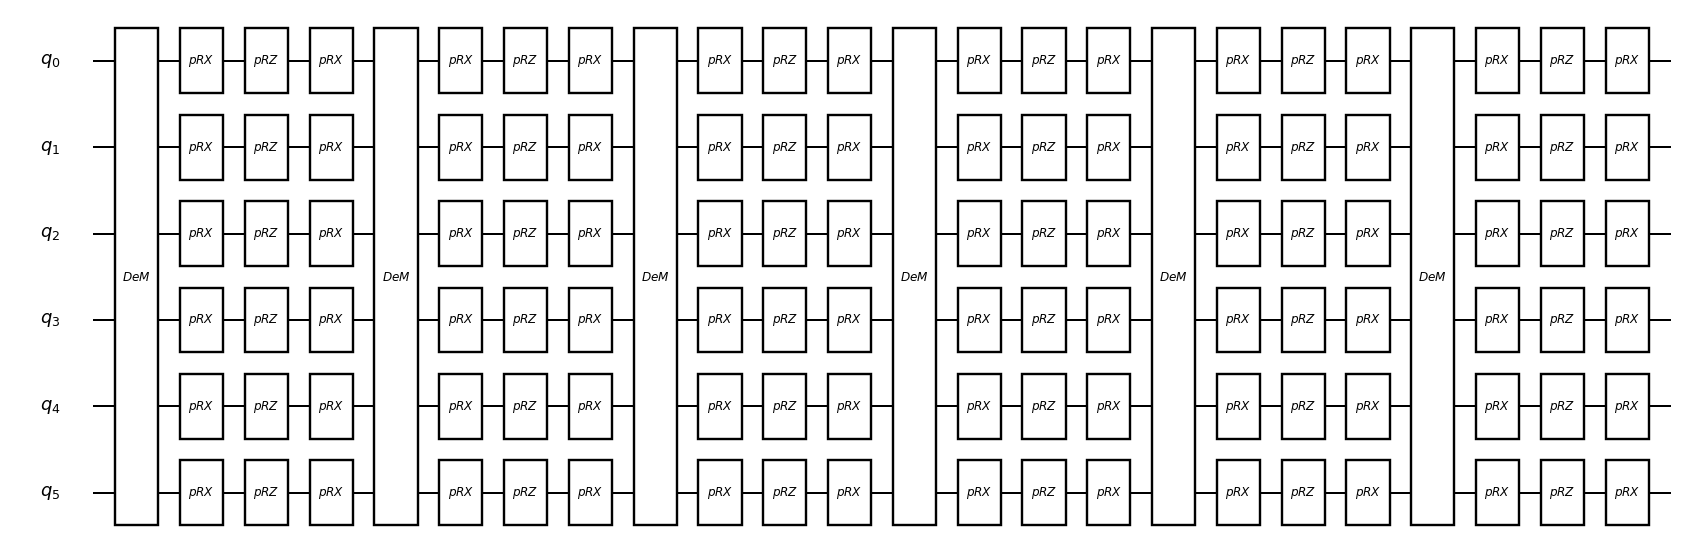

In [ ]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')

The ```ParametricQuantumCircuit``` class from the qulacs library is used to create a quantum circuit that can have its gate parameters changed.

```U_out = ParametricQuantumCircuit(nqubit)``` creates a new ```ParametricQuantumCircuit``` with ```nqubit``` number of qubits. ```nqubit``` is not defined in the provided code, so it should be defined elsewhere in your program.

The for loop adds gates to the quantum circuit. For each iteration of the loop:

```U_out.add_gate(time_evol_gate)```: This line adds a gate to the circuit. The type of gate is not specified in the provided code, so ```time_evol_gate``` should be defined elsewhere in your program. The inner for loop adds three parametric gates (RX, RZ, and RX again) to each qubit in the circuit. The angle for each gate is randomly generated.
parameter_count = ```U_out.get_parameter_count()``` This line gets the total number of parameters in the circuit. In this case, it should be 3 * nqubit * c_depth because three parametric gates are added to each qubit for each iteration of the outer loop.

```theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]```: This line creates a list of the initial values of the parameters in the circuit. This list can be used later to change the parameters of the circuit.

Later, a function named ```set_U_out``` is defined to update parameter $\theta$ in $U(\theta)$ 

In [ ]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

## Measurement

In this demostration, the output of the model will be taken from the expectation value of the Pauli Z operator of the first two qubits acting on output state $\ket{\psi_{out}}$. This values will then be transformed by the softmax function $\mathbf{F}$. For the d-dimensional vector $\mathbf{q}$, the softmax function returns the d-dimensional vector $\mathbf{F(\mathbf{q})}$, with its kth element being $\mathbf{F_k(\mathbf{q})} = e^{q_k}/\sum_i e^{q_i}$

$y(\theta,x_i)=\left<\psi_\text{out}|Z_0|\psi_\text{out}\right> $

In [ ]:
def softmax(v):
    e_k = np.exp(v - np.max(v))
    return e_k / e_k.sum(axis=0)

In [ ]:
# Create observable Z_0
from qulacs import Observable

def get_output(state):

    z0 = Observable(nqubit)
    z0.add_operator(1.,'Z 0') # a = 1
    z0_val = z0.get_expectation_value(state)

    z1 = Observable(nqubit)
    z1.add_operator(1.,'Z 1') # a = 1
    z1_val = z1.get_expectation_value(state)

    res = softmax(np.asarray([z0_val, z1_val]))
    
    return res

In [ ]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(sample, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(sample).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res =get_output(state)

    return res

### Calculation of cost function

We use the cross entropy cost function

In [ ]:
def cross_entropy(f_pred, f_train):
    loss = 0
    for i in range(len(f_pred)):
        for k in range(2):
            loss +=-f_train[i][k] * np.log(f_pred[i][k])

    return loss


In [ ]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    predicted_output = [qcl_pred(sample, U_out) for sample in train_samples]

    # quadratic loss
    L = cross_entropy(predicted_output, f_train)

    return L

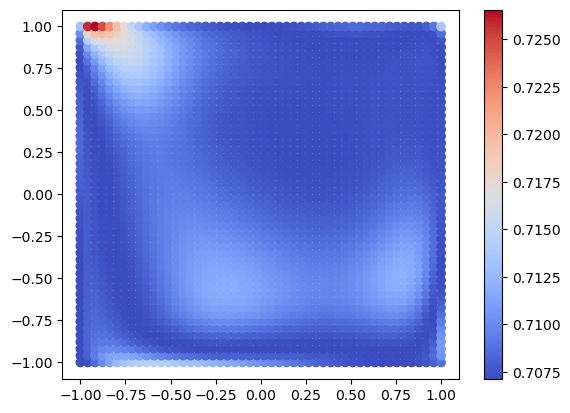

In [ ]:
num_test_samples = 500

# r_min = 0.; r_max = 1
# r_test = r_min + (r_max - r_min) * np.random.rand(num_test_samples)
# theta_test = 2.0 * np.pi * np.random.rand(num_test_samples)

# x_test= r_test * np.cos(theta_test)
# y_test= r_test * np.sin(theta_test)

x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)

# Create a meshgrid
x_test, y_test = np.meshgrid(x, y)
x_test = x_test.flatten()
y_test = y_test.flatten()

test_samples = [np.asarray([x_test[i],y_test[i]]) for i in range(len(x_test))]

# Initial prediction
initial_prediction = [qcl_pred(sample, U_out) for sample in test_samples]
color_initial_prediction = [np.sqrt(p[0]**2+p[1]**2) for p in initial_prediction]

plt.scatter(x_test, y_test, c=color_initial_prediction, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()

In [ ]:
from scipy.optimize import minimize

result = minimize(cost_func, theta_init, method='BFGS')
result.fun

96.08739487981698

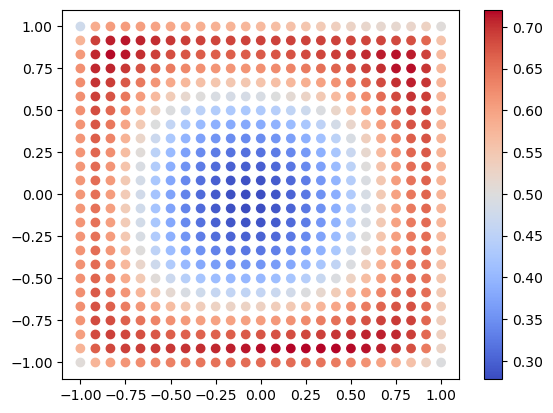

In [ ]:
num_test_samples = 50

# r_min = 0.; r_max = 1
# r_test = r_min + (r_max - r_min) * np.random.rand(num_test_samples)
# theta_test = 2.0 * np.pi * np.random.rand(num_test_samples)

# x_test= r_test * np.cos(theta_test)
# y_test= r_test * np.sin(theta_test)

x = np.linspace(-1, 1, 25)
y = np.linspace(-1, 1, 25)

# Create a meshgrid
x_test, y_test = np.meshgrid(x, y)
x_test = x_test.flatten()
y_test = y_test.flatten()

test_samples = [np.asarray([x_test[i],y_test[i]]) for i in range(len(x_test))]
# Initial prediction
final_prediction = [qcl_pred(z, U_out) for z in test_samples]
color_final_pred = [p[0] for p in final_prediction]

plt.scatter(x_test, y_test, c=color_final_pred, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()

### References

[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, Phys. Rev. A 98, 032309 (2018), arXiv：https://arxiv.org/abs/1803.00745
